In [56]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
files = ['^W5000.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv']

df = pd.read_csv('AMZN.csv')
df.set_index('Date')['Close']

Date
2017-07-10     49.823502
2017-07-11     49.706501
2017-07-12     50.325500
2017-07-13     50.031502
2017-07-14     50.090500
                 ...    
2022-07-01    109.559998
2022-07-05    113.500000
2022-07-06    114.330002
2022-07-07    116.330002
2022-07-08    115.540001
Name: Close, Length: 1259, dtype: float64

In [53]:
x = np.log(1.0 + df['Close'].pct_change(1).dropna().to_numpy())
sim = np.random.choice(x, (1259, 10), replace=True)

In [54]:
S0 = 49.823502
S0 * np.exp(np.cumsum(sim,axis=0))[:,5]

array([50.81712273, 53.47942146, 54.237179  , ..., 60.87645867,
       61.13960172, 61.25700649])

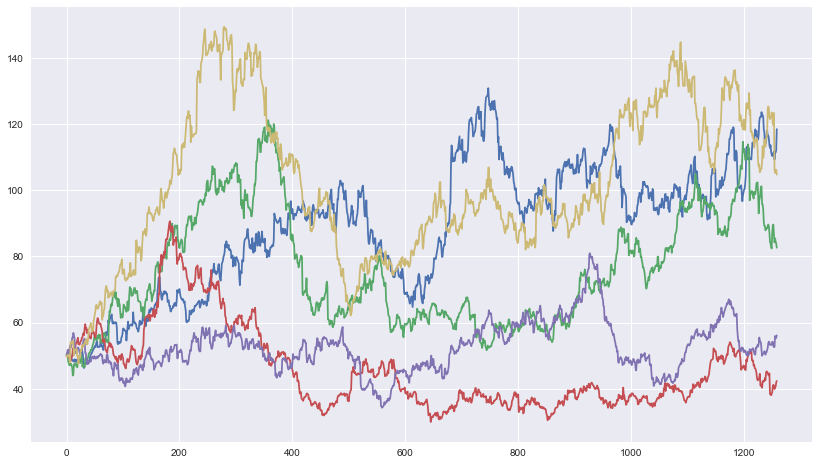

In [61]:
plt.figure(figsize = [14, 8])
for i in range(5):
    plt.plot(S0 * np.exp(np.cumsum(sim,axis=0))[:,i])

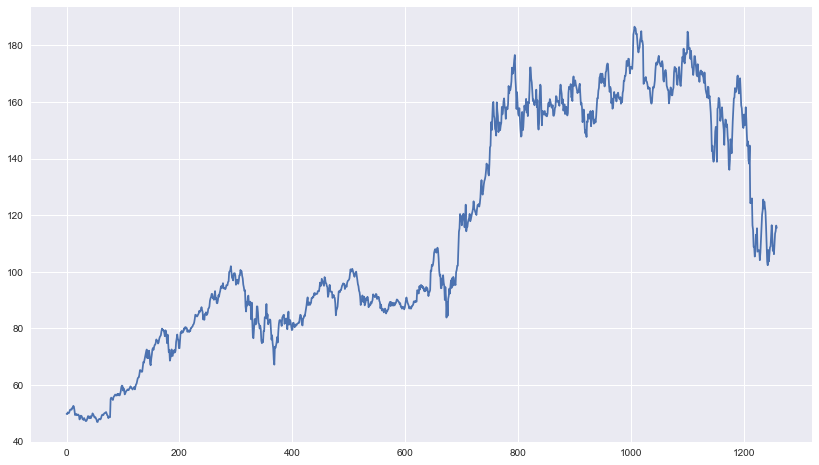

In [62]:
plt.figure(figsize = [14, 8])
plt.plot(df['Close'])

In [222]:
import arch
import numpy as np
from arch.univariate import ARX

S0 = 49.823502

df = pd.read_csv('AMZN.csv')
df.set_index('Date')['Close']
x = np.log(1.0 + df['Close'].pct_change(1).dropna().to_numpy())

garch = arch.arch_model(100*x, vol='garch', p=1, o=1, q=1)
garch_fitted = garch.fit()
arx = ARX(100*x, lags=[1, 2])
res = arx.fit()

sim_arx = []
for _ in range(5000):
    sim = arx.simulate(res.params, 60, initial_value_vol = 0.02) / 100
    sim_arx.append(sim['data'].to_numpy())
    
sim_arx = np.array(sim_arx).T
ST_arx = S0 * np.exp(np.cumsum(sim_arx,axis=0))[-1]

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6644.338194183032
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3641.0395271678058
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2741.295015619058
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2597.2945994745714
Iteration:      5,   Func. Count:     37,   Neg. LLF: 5479.752670736116
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2617.7066702430193
Iteration:      7,   Func. Count:     52,   Neg. LLF: 2619.5263530198317
Iteration:      8,   Func. Count:     60,   Neg. LLF: 2606.4421861232313
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2582.0030308467462
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2582.0018401270418
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2582.0018321935922
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2582.0018316579362
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2582.0018316579362
            Iterat

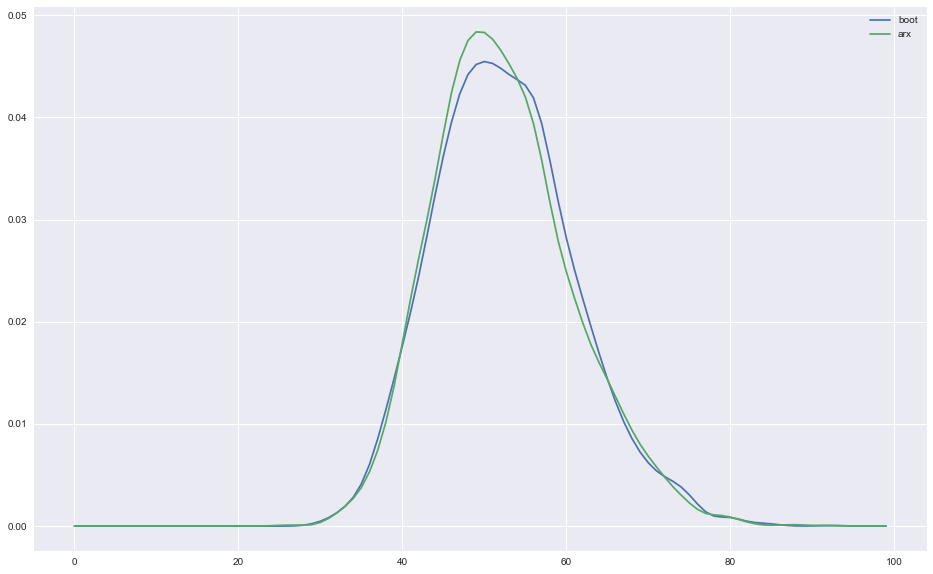

In [443]:
from scipy.stats import gaussian_kde

sim = np.random.choice(x, (60, 5000), replace=True)
ST = S0 * np.exp(np.cumsum(sim,axis=0))[-1]

bins = np.arange(0.0, 100.0, 1.0)

kernel_p = gaussian_kde(ST)
kernel_arx = gaussian_kde(ST_arx)
scores_p = kernel_p(bins)
scores_arx = kernel_arx(bins)

plt.figure(figsize=[16,10])
plt.plot(bins, scores_p, label='boot')
plt.plot(bins, scores_arx, label='arx')

plt.legend()

In [444]:
boot_sample = kernel_p.resample(size=10000).flatten()
arx_sample = kernel_arx.resample(size=10000).flatten()

In [445]:
def TerminalVanillaPayoff(putStrikes, callStrikes, ST):
    payoffs = []
    labels = []
    
    for strike in putStrikes:
        payoffs.append(np.maximum(strike - ST, 0))
        labels.append(str(strike) + ' Put')
    for strike in callStrikes:
        payoffs.append(np.maximum(ST - strike, 0))
        labels.append(str(strike) + ' Call')
    return payoffs, labels

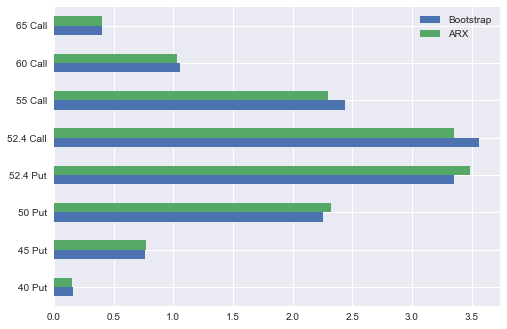

In [446]:
putStrikes = [40, 45, 50, 52.4]
callStrikes = [52.4, 55, 60, 65]

payoffBoot, labelBoot = TerminalVanillaPayoff(putStrikes, callStrikes, boot_sample)
payoffArx, labelBoot = TerminalVanillaPayoff(putStrikes, callStrikes, arx_sample)
priceBoot = np.mean(payoffBoot, 1) 
priceArx = np.mean(payoffArx, 1)

df = pd.DataFrame({'Bootstrap': priceBoot,
                   'ARX': priceArx}, index=labelBoot)
ax = df.plot.barh()


In [447]:
df

,Bootstrap,ARX
40 Put,0.159989,0.154739
45 Put,0.766310,0.769793
50 Put,2.252095,2.318856
52.4 Put,3.355405,3.483816
52.4 Call,3.561231,3.348982
55 Call,2.436947,2.297736
60 Call,1.053876,1.034122
65 Call,0.405981,0.405890


In [473]:
from scipy.optimize import fmin_bfgs

numPath = 10000
boot_sample = kernel_p.resample(size=numPath).flatten()
priceMarket = np.array([0.6, 1.5, 2.8, 3.7, 3.8, 2.7, 1.6, 1.0])

payoffBoot, labelBoot = TerminalVanillaPayoff(putStrikes, callStrikes, boot_sample)
priceBoot = np.mean(payoffBoot, 1) 

prices_tiled = np.tile(priceMarket, numPath).reshape(numPath, -1).T
n_assets = prices_tiled.shape[0]

deltas = np.array(payoffBoot) - prices_tiled

def W0(lambdas):
    n_assets = deltas.shape[0]
    n_paths = deltas.shape[1]
    return np.log(np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets))

lambdas = fmin_bfgs(W0, np.zeros(n_assets))

Z0 = np.sum(np.exp(np.matmul(lambdas, deltas)) / n_assets)
m = (np.exp(np.matmul(lambdas, deltas)) / n_assets) / Z0

Optimization terminated successfully.
         Current function value: 6.922280
         Iterations: 24
         Function evaluations: 243
         Gradient evaluations: 27


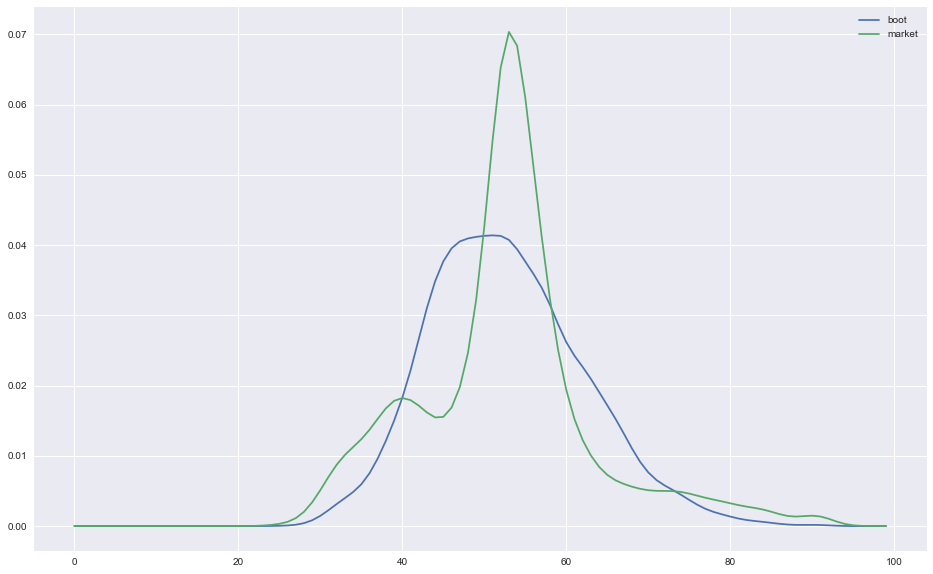

In [476]:
from scipy.stats import gaussian_kde

bins = np.arange(0.0, 100.0, 1.0)

kernel_p = gaussian_kde(boot_sample)
kernel_q = gaussian_kde(boot_sample, weights = m)
scores_p = kernel_p(bins)
scores_q = kernel_q(bins)

plt.figure(figsize=[16,10])
plt.plot(bins, scores_p, label='boot')
plt.plot(bins, scores_q, label='market')

plt.legend()

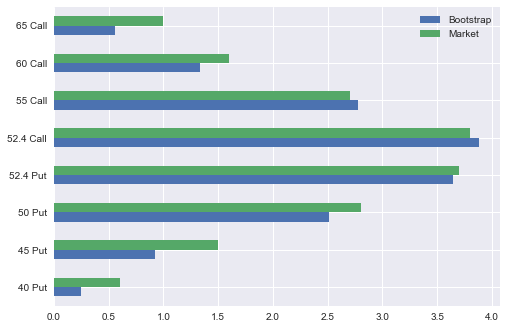

In [477]:
df = pd.DataFrame({'Bootstrap': priceBoot,
                   'Market': priceMarket}, index=labelBoot)
ax = df.plot.barh()
